In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import time
import scipy.stats
from tqdm import tqdm
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.forcing.ghg import meinshausen2020

In [2]:
erf_2co2 = meinshausen2020(
    np.array([554.30, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array([277.15, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array((1.05, 0.86, 1.07)) * np.ones((1, 1, 1, 1)),
    np.ones((1, 1, 1, 3)),
    np.array([True, False, False]),
    np.array([False, True, False]),
    np.array([False, False, True]),
    np.array([False, False, False])
).squeeze()[0]
erf_2co2

3.9334694485974606

In [3]:
scenarios = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

In [4]:
df_forc = pd.read_csv('../data_input/table_A3.3_historical_ERF_1750-2019_best_estimate.csv')
df_solar = pd.read_csv('../data_input/solar_erf.csv', index_col='year')

In [5]:
solar_forcing = np.zeros(537)
solar_forcing[:535] = df_solar['solar_erf'].loc[1765.5:2300].values
volcanic_forcing = np.zeros(537)
volcanic_forcing[:255] = df_forc['volcanic'].values[15:]
volcanic_forcing[254:266] = np.linspace(1, 0, 12) * volcanic_forcing[254]

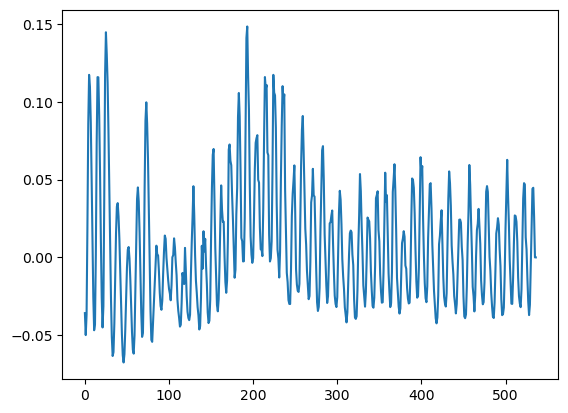

In [6]:
pl.plot(solar_forcing)

In [7]:
da_emissions = xr.load_dataarray('../data_input/rcp_emissions_fair2.1.nc')

In [8]:
species = [
    'CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O',
    'Sulfur', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO',
    'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115',
    'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CH3Cl', 'CH3CCl3', 'CH3Br',
    'Halon-1211', 'Halon-1202', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C6F14',
    'SF6',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-227ea', 'HFC-23', 'HFC-245fa', 'HFC-32', 
    'HFC-4310mee', 'Solar', 'Volcanic', 'Aerosol-radiation interactions',
    'Aerosol-cloud interactions', 'Ozone', 'Light absorbing particles on snow and ice',
    'Land use', 'Stratospheric water vapour', 'Equivalent effective stratospheric chlorine',
    'Contrails', 'NOx aviation'
]

species, properties = read_properties(species=species)

In [9]:
df_configs = pd.read_csv('../data_input/ar6_calibration_ebm3_rcp.csv', index_col=0)
configs = np.array(list(df_configs.index))
print(configs)

[    128    2723    4007 ... 1497822 1497981 1499429]


H:\conda\rff-fair2.1\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.499968923001461

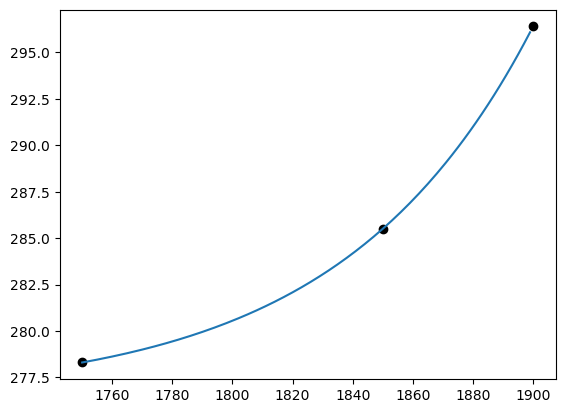

In [10]:
# using an extremely crude curve fit to estimate 1765 CO2

obs_co2 = np.array([278.3, 285.5, 296.4])
obs_years = [1750, 1850, 1900]

def fit(x, a, b, c):
    return a + b*np.exp(c*(x-1750))

p, _ = scipy.optimize.curve_fit(fit, obs_years, obs_co2, p0=[278.3, 1.45, 0.0171])
pl.plot(np.arange(1750, 1900), p[0]+p[1]*np.exp(p[2] * (np.arange(1750, 1900)-1750)))
pl.scatter(obs_years, obs_co2, color='k')

offset1765co2 = fit(1765, p[0], p[1], p[2]) - fit(1750, p[0], p[1], p[2])
offset1765co2

734.6900306816502

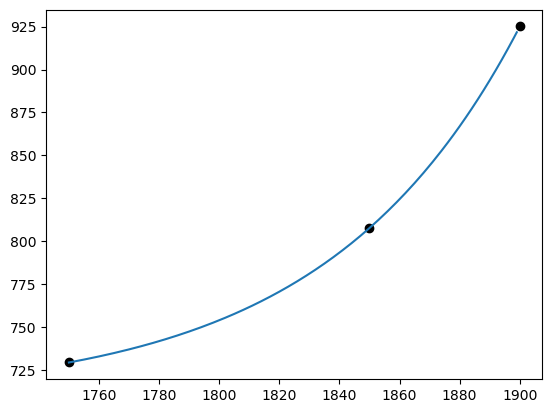

In [11]:
obs_ch4 = np.array([729.2, 807.6, 925.1])
obs_years = [1750, 1850, 1900]

def fit(x, a, b, c):
    return a + b*np.exp(c*(x-1750))

p, _ = scipy.optimize.curve_fit(fit, obs_years, obs_ch4, p0=[278.3, 1.45, 0.0171])
pl.plot(np.arange(1750, 1900), p[0]+p[1]*np.exp(p[2] * (np.arange(1750, 1900)-1750)))
pl.scatter(obs_years, obs_ch4, color='k')

baseline1765ch4 = fit(1765, p[0], p[1], p[2])
baseline1765ch4

270.1645163347935

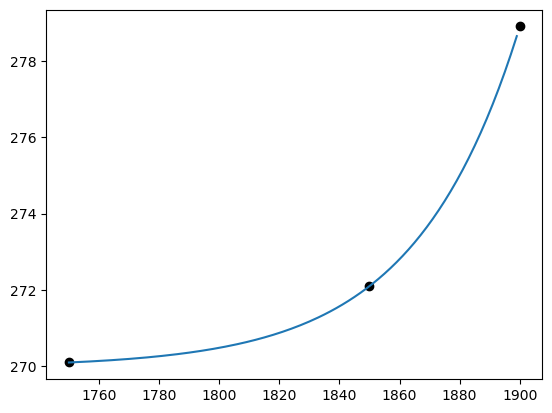

In [12]:
obs_n2o = np.array([270.1, 272.1, 278.9])
obs_years = [1750, 1850, 1900]

def fit(x, a, b, c):
    return a + b*np.exp(c*(x-1750))

p, _ = scipy.optimize.curve_fit(fit, obs_years, obs_n2o, p0=[278.3, 1.45, 0.0171])
pl.plot(np.arange(1750, 1900), p[0]+p[1]*np.exp(p[2] * (np.arange(1750, 1900)-1750)))
pl.scatter(obs_years, obs_n2o, color='k')

baseline1765n2o = fit(1765, p[0], p[1], p[2])
baseline1765n2o

In [13]:
trend_shape = np.ones(537)
trend_shape[:256] = np.linspace(0, 1, 256)

In [14]:
f = FAIR(ch4_method='Thornhill2021')
f.define_time(1765, 2301, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)
f.allocate()

In [15]:
f.emissions[:,:,:,:]

<xarray.DataArray (timepoints: 536, scenario: 4, config: 1001, specie: 51)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.766e+03 1.766e+03 ... 2.3e+03 2.3e+03
  * scenario    (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * config      (config) int32 128 2723 4007 5263 ... 1497822 1497981 1499429
  * specie      (specie) <U43 'CO2 FFI' 'CO2 AFOLU' ... 'NOx aviation'

In [16]:
#f.fill_from_rcmip()

for iscen, scenario in enumerate(scenarios):
    da = da_emissions.loc[dict(config='unspecified', scenario=scenario)][:536, ...]
    fe = da.expand_dims(dim=['scenario', 'config'], axis=(1, 2))
    f.emissions[:,iscen:iscen+1,:,:] = fe.drop('config') * np.ones((1,1,len(configs),1))
    f.emissions[:86,iscen,0,5] = np.linspace(2, f.emissions[85,iscen,0,5], 86)
    f.emissions[:86,iscen,0,6] = np.linspace(1.2, f.emissions[85,iscen,0,6], 86)
    f.emissions[:86,iscen,0,7] = np.linspace(10, f.emissions[85,iscen,0,7], 86)
    f.emissions[:86,iscen,0,8] = np.linspace(4, f.emissions[85,iscen,0,8], 86)
    f.emissions[:86,iscen,0,9] = np.linspace(46/14*2, f.emissions[85,iscen,0,9], 86)
    f.emissions[:86,iscen,0,10] = np.linspace(10, f.emissions[85,iscen,0,10], 86)
    f.emissions[:86,iscen,0,11] = np.linspace(174, f.emissions[85,iscen,0,11], 86)

In [17]:
calibrated_f4co2_mean = df_configs['F_4xCO2'].mean()

fill(f.forcing, volcanic_forcing[:, None, None] * df_configs.loc[configs, 'scale Volcanic'].values.squeeze(), specie='Volcanic')
fill(f.forcing, 
     solar_forcing[:, None, None] * 
     df_configs.loc[configs, 'solar_amplitude'].values.squeeze() + 
     trend_shape[:, None, None] * df_configs.loc[configs, 'solar_trend'].values.squeeze(),
     specie='Solar'
)

# climate response
fill(f.climate_configs['ocean_heat_capacity'], df_configs.loc[configs, 'c1':'c3'].values)
fill(f.climate_configs['ocean_heat_transfer'], df_configs.loc[configs, 'kappa1':'kappa3'].values)
fill(f.climate_configs['deep_ocean_efficacy'], df_configs.loc[configs, 'epsilon'].values.squeeze())
fill(f.climate_configs['gamma_autocorrelation'], df_configs.loc[configs, 'gamma'].values.squeeze())
fill(f.climate_configs['sigma_eta'], df_configs.loc[configs, 'sigma_eta'].values.squeeze())
fill(f.climate_configs['sigma_xi'], df_configs.loc[configs, 'sigma_xi'].values.squeeze())
fill(f.climate_configs['stochastic_run'], False)
fill(f.climate_configs['use_seed'], False)
fill(f.climate_configs['forcing_4co2'], 2 * erf_2co2 * (1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[configs,'F_4xCO2'])/calibrated_f4co2_mean))

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs['iirf_0'], df_configs.loc[configs, 'r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], df_configs.loc[configs, 'rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], df_configs.loc[configs, 'rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], df_configs.loc[configs, 'rT'].values.squeeze(), specie='CO2')

# aerosol indirect
fill(f.species_configs['aci_scale'], df_configs.loc[configs, 'beta'].values.squeeze())
fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_so2'].values.squeeze(), specie='Sulfur')
fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_bc'].values.squeeze(), specie='BC')
fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_oc'].values.squeeze(), specie='OC')

# methane lifetime baseline
fill(f.species_configs['unperturbed_lifetime'], 10.4198121, specie='CH4')

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people might wanna run pulse expts with these gases)
fill(f.species_configs['baseline_emissions'], 19.019783117809567, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

# aerosol direct
for specie in ['BC', 'CH4', 'N2O', 'NH3', 'NOx', 'OC', 'Sulfur', 'VOC', 'Equivalent effective stratospheric chlorine']:
    fill(f.species_configs['erfari_radiative_efficiency'], df_configs.loc[configs, f"ari {specie}"], specie=specie)

# forcing
for specie in ['CH4', 'N2O', 'Stratospheric water vapour', 'Contrails', 'Light absorbing particles on snow and ice', 'Land use']:
    fill(f.species_configs['forcing_scale'], df_configs.loc[configs, f"scale {specie}"].values.squeeze(), specie=specie)
for specie in ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
        'CCl4', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2402',
        'CF4', 'C2F6', 'C6F14', 'SF6',
        'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-227ea', 'HFC-23', 'HFC-245fa', 'HFC-32', 'HFC-4310mee']:
    fill(f.species_configs['forcing_scale'], df_configs.loc[configs, 'scale minorGHG'].values.squeeze(), specie=specie)
fill(f.species_configs['forcing_scale'], 1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[configs,'F_4xCO2'].values)/calibrated_f4co2_mean, specie='CO2')

# ozone
for specie in ['CH4', 'N2O', 'CO', 'NOx', 'VOC', 'Equivalent effective stratospheric chlorine']:
    fill(f.species_configs['ozone_radiative_efficiency'], df_configs.loc[configs, f"o3 {specie}"], specie=specie)

# tune down volcanic efficacy
fill(f.species_configs['forcing_efficacy'], 0.6, specie='Volcanic')


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], offset1765co2 + df_configs.loc[configs, 'co2_concentration_1750'].values.squeeze(), specie='CO2')

# initial condition of other species
fill(f.species_configs['baseline_concentration'], baseline1765ch4, specie='CH4')
fill(f.species_configs['baseline_concentration'], baseline1765n2o, specie='N2O')
fill(f.species_configs['baseline_emissions'], 2, specie='Sulfur')
fill(f.species_configs['baseline_emissions'], 174, specie='CO')
fill(f.species_configs['baseline_emissions'], 10, specie='VOC')
fill(f.species_configs['baseline_emissions'], 4, specie='NH3')
fill(f.species_configs['baseline_emissions'], 2*46/14, specie='NOx')
fill(f.species_configs['baseline_emissions'], 1.2, specie='BC')
fill(f.species_configs['baseline_emissions'], 10, specie='OC')

# initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

f.run()

Running 4004 projections in parallel:   0%|          | 0/536 [00:00<?, ?timesteps/s]

Text(0.5, 0.98, 'Temperature anomaly')

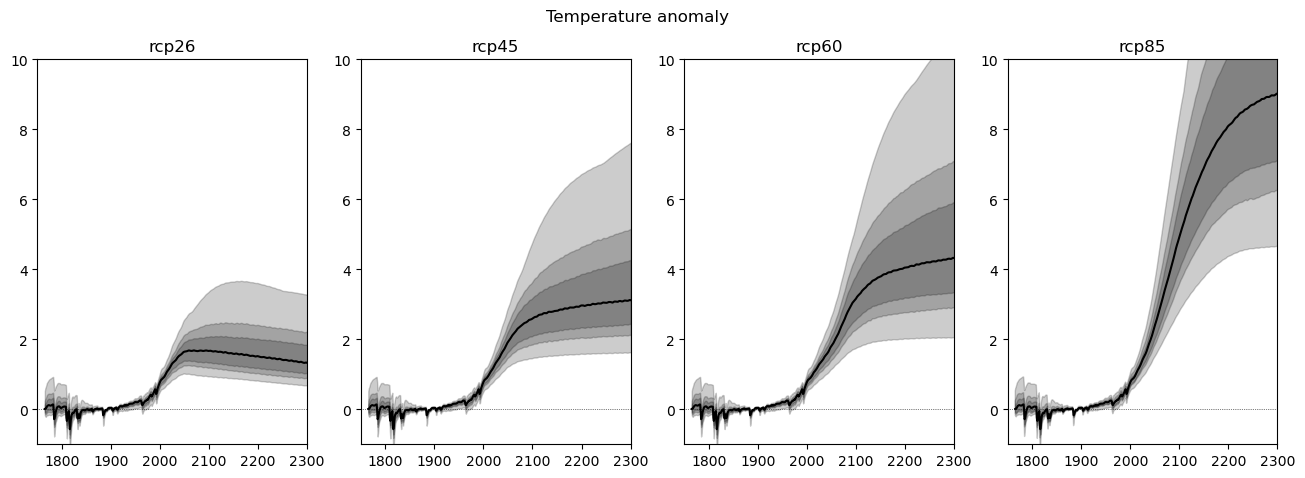

In [18]:
fig, ax = pl.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].fill_between(
        f.timebounds, 
        np.min(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), axis=1), 
        np.max(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), axis=1),
        color='#000000',
        alpha=0.2,
    )
    ax[i].fill_between(
        f.timebounds, 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 5, axis=1), 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 95, axis=1),
        color='#000000',
        alpha=0.2,
    )
    ax[i].fill_between(
        f.timebounds, 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 16, axis=1), 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 84, axis=1),
        color='#000000',
        alpha=0.2,
    )
    ax[i].plot(
        f.timebounds, 
        np.median(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), axis=1), 
        color='#000000',
    )
    ax[i].set_xlim(1750,2300)
    ax[i].set_ylim(-1, 10)
    ax[i].axhline(0, color='k', ls=":", lw=0.5)
    ax[i].set_title(scenarios[i])
pl.suptitle('Temperature anomaly')

In [19]:
for iscen, scenario in enumerate(scenarios):
    ds = xr.Dataset(
        {
            "temperature": (["year", "run"], (f.temperature[:, iscen, :, 0] - f.temperature[100:151, iscen, :, 0].mean(axis=0)).data),
            "effective_radiative_forcing": (["year", "run"], f.forcing_sum[:, iscen, :].data),
            "ocean_heat_content_change": (["year", "run"], f.ocean_heat_content_change[:, iscen, :].data),
            "co2_concentration": (["year", "run"], f.concentration[:, iscen, :, 2].data),
            "ch4_concentration": (["year", "run"], f.concentration[:, iscen, :, 3].data),
            "n2o_concentration": (["year"], f.concentration[:, iscen, 0, 4].data),
        },
        coords={
            "year": f.timebounds,
            "run": configs
        },
    )
    ds.to_netcdf('../data_output/deterministic/%s.nc' % scenario)
    ds.close()

In [20]:
species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'BC',
 'OC',
 'NH3',
 'NOx',
 'VOC',
 'CO',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1202',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C6F14',
 'SF6',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-227ea',
 'HFC-23',
 'HFC-245fa',
 'HFC-32',
 'HFC-4310mee',
 'Solar',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
 'Ozone',
 'Light absorbing particles on snow and ice',
 'Land use',
 'Stratospheric water vapour',
 'Equivalent effective stratospheric chlorine',
 'Contrails',
 'NOx aviation']